# Testing MHW Systems

In [50]:
# imports
from importlib import reload
import numpy as np
import os
from matplotlib import pyplot as plt
from pkg_resources import resource_filename

from datetime import date

import pandas
import sqlalchemy
import iris
import iris.quickplot as qplt

import h5py

from oceanpy.sst import io as sst_io
from oceanpy.sst import utils as sst_utils
from mhw_analysis.systems import cube as mhw_cube
from mhw_analysis.systems import build as mhw_build
from mhw_analysis.systems import io as mhw_sys_io

# Load a few things for guidance

In [2]:
SST = sst_io.load_noaa((1, 1, 2014))

In [3]:
SST

<iris 'Cube' of Daily Sea Surface Temperature / (degC) (latitude: 720; longitude: 1440)>

In [4]:
lats = SST.coord('latitude').points
lats[lats>40.]

array([40.125, 40.375, 40.625, 40.875, 41.125, 41.375, 41.625, 41.875,
       42.125, 42.375, 42.625, 42.875, 43.125, 43.375, 43.625, 43.875,
       44.125, 44.375, 44.625, 44.875, 45.125, 45.375, 45.625, 45.875,
       46.125, 46.375, 46.625, 46.875, 47.125, 47.375, 47.625, 47.875,
       48.125, 48.375, 48.625, 48.875, 49.125, 49.375, 49.625, 49.875,
       50.125, 50.375, 50.625, 50.875, 51.125, 51.375, 51.625, 51.875,
       52.125, 52.375, 52.625, 52.875, 53.125, 53.375, 53.625, 53.875,
       54.125, 54.375, 54.625, 54.875, 55.125, 55.375, 55.625, 55.875,
       56.125, 56.375, 56.625, 56.875, 57.125, 57.375, 57.625, 57.875,
       58.125, 58.375, 58.625, 58.875, 59.125, 59.375, 59.625, 59.875,
       60.125, 60.375, 60.625, 60.875, 61.125, 61.375, 61.625, 61.875,
       62.125, 62.375, 62.625, 62.875, 63.125, 63.375, 63.625, 63.875,
       64.125, 64.375, 64.625, 64.875, 65.125, 65.375, 65.625, 65.875,
       66.125, 66.375, 66.625, 66.875, 67.125, 67.375, 67.625, 67.875,
      

In [5]:
lons = SST.coord('longitude').points
lons[(lons > 200) & (lons < 230)]

array([200.125, 200.375, 200.625, 200.875, 201.125, 201.375, 201.625,
       201.875, 202.125, 202.375, 202.625, 202.875, 203.125, 203.375,
       203.625, 203.875, 204.125, 204.375, 204.625, 204.875, 205.125,
       205.375, 205.625, 205.875, 206.125, 206.375, 206.625, 206.875,
       207.125, 207.375, 207.625, 207.875, 208.125, 208.375, 208.625,
       208.875, 209.125, 209.375, 209.625, 209.875, 210.125, 210.375,
       210.625, 210.875, 211.125, 211.375, 211.625, 211.875, 212.125,
       212.375, 212.625, 212.875, 213.125, 213.375, 213.625, 213.875,
       214.125, 214.375, 214.625, 214.875, 215.125, 215.375, 215.625,
       215.875, 216.125, 216.375, 216.625, 216.875, 217.125, 217.375,
       217.625, 217.875, 218.125, 218.375, 218.625, 218.875, 219.125,
       219.375, 219.625, 219.875, 220.125, 220.375, 220.625, 220.875,
       221.125, 221.375, 221.625, 221.875, 222.125, 222.375, 222.625,
       222.875, 223.125, 223.375, 223.625, 223.875, 224.125, 224.375,
       224.625, 224.

# Generate a faux pandas MHW Event table

## Pacific

### Locations

In [6]:
pac_lons = lons[(lons > 200) & (lons < 230)]
pac_lons.size

120

In [7]:
pac_lats = lats[(lats>40.) & (lats < 60.)]
pac_lats.size

80

In [8]:
pac_XX, pac_YY = np.meshgrid(pac_lons, pac_lats)

In [9]:
pac_XX.shape

(80, 120)

### Times

In [10]:
pac_date_end = date(2013, 12, 31)
pac_date_end.toordinal()

735233

In [11]:
rand_dur = np.random.randint(5,100, pac_lats.size*pac_lons.size).reshape((80,120))
rand_dur

array([[ 8, 32, 65, ..., 41, 77, 54],
       [20, 70, 46, ..., 16, 70, 32],
       [97, 84, 29, ..., 19, 62, 73],
       ...,
       [26, 75, 23, ..., 15,  9, 52],
       [42, 53, 90, ..., 28, 45, 93],
       [50, 48, 48, ..., 27, 39, 50]])

In [12]:
pac_start = pac_date_end.toordinal() - rand_dur

In [13]:
pac_start.shape

(80, 120)

### Random categories

In [14]:
ran_cat = np.random.randint(0,4, pac_lats.size*pac_lons.size).reshape((80,120))

### Build em

In [15]:
pac_mhw_events = dict(lat=[], lon=[], duration=[], time_start=[], category=[])
for ii in range(pac_start.shape[0]):
    for jj in range(pac_start.shape[1]):
        # Fill it up
        pac_mhw_events['lat'].append(pac_YY[ii,jj])
        pac_mhw_events['lon'].append(pac_XX[ii,jj])
        pac_mhw_events['duration'].append(rand_dur[ii,jj])
        pac_mhw_events['time_start'].append(pac_start[ii,jj])
        pac_mhw_events['category'].append(ran_cat[ii,jj])

In [16]:
pac_tbl = pandas.DataFrame(pac_mhw_events)

In [17]:
pac_tbl.head()

,lat,lon,duration,time_start,category
0,40.125,200.125,8,735225,1
1,40.125,200.375,32,735201,2
2,40.125,200.625,65,735168,3
3,40.125,200.875,65,735168,1
4,40.125,201.125,38,735195,1


## Atlantic

In [18]:
atl_lons = lons[(lons > (360-70)) & (lons < (360-20))]
atl_lats = lats[(lats > 10) & (lats < 50)]

In [19]:
atl_XX, atl_YY = np.meshgrid(atl_lons, atl_lats)
atl_XX = atl_XX.flatten()
atl_YY = atl_YY.flatten()
atl_XX.shape

(32000,)

In [20]:
nrand_atl = 500

In [21]:
pos_rand = np.random.choice(np.arange(atl_XX.size), nrand_atl, replace=False)
pos_rand[0:5]

array([18147, 11306, 26761,  1730,  7687])

### Time

In [22]:
atl_dur = 7

In [23]:
atl_start = pac_date_end.toordinal() - np.random.randint(10,100, nrand_atl)

In [24]:
atl_cat = np.random.randint(0,4, nrand_atl)

### Build em

In [25]:
atl_mhw_events = dict(lat=[], lon=[], duration=[], time_start=[], category=[])
for ii in range(nrand_atl):
    # Fill it up
    atl_mhw_events['lat'].append(atl_YY[pos_rand[ii]])
    atl_mhw_events['lon'].append(atl_XX[pos_rand[ii]])
    atl_mhw_events['duration'].append(atl_dur)
    atl_mhw_events['time_start'].append(atl_start[ii])
    atl_mhw_events['category'].append(atl_cat[ii])

In [26]:
atl_tbl = pandas.DataFrame(atl_mhw_events)

In [27]:
atl_tbl.head()

,lat,lon,duration,time_start,category
0,32.625,326.875,7,735148,1
1,24.125,316.625,7,735161,2
2,43.375,330.375,7,735222,0
3,12.125,322.625,7,735169,0
4,19.625,311.875,7,735167,2


## Combine

In [28]:
mhw_tbl = pandas.concat([pac_tbl, atl_tbl])
mhw_tbl.head()

,lat,lon,duration,time_start,category
0,40.125,200.125,8,735225,1
1,40.125,200.375,32,735201,2
2,40.125,200.625,65,735168,3
3,40.125,200.875,65,735168,1
4,40.125,201.125,38,735195,1


# Cube

In [29]:
reload(mhw_cube)
cube = mhw_cube.build_cube('test_cube.npz', mhw_events=mhw_tbl, dmy_start=(2013,1,1), dmy_end=(2013,12,31))

Events are loaded
kk = 0
Wrote: test_cube.npz


In [30]:
np.max(cube), cube.dtype

(4, dtype('int8'))

# Systems

## Build

In [34]:
reload(mhw_build)
mhw_sys, mhw_mask = mhw_build.main(cube=cube, mhwsys_file='test_mhw_systems.hdf',
                                  dmy_start=(1983,1,1))

Entering first_pass_c
First pass complete
Second pass complete
NObj Extracted= 495
Nobj Detected = 495
Objects nearly done
area done
Wrote: test_mhw_systems.hdf


/home/xavier/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->date,key->block3_values] [items->Index(['date'], dtype='object')]

  encoding=encoding,


Wrote: test_mhw_mask.npz


## Explore

In [35]:
mhw_sys = mhw_sys.sort_values('NSpax', ascending=False)
mhw_sys

,NSpax,category,mask_Id,max_area,xcen,xboxmin,xboxmax,ycen,yboxmin,yboxmax,zcen,zboxmin,zboxmax,date,lat,lon
Id,,,,,,,,,,,,,,,,
368,495879,4,369,9600,559.14209,520,599,859.130127,800,919,329.895874,265,363,1983-11-26,49.910522,214.907532
95,14,2,96,2,432.00000,432,433,1173.500000,1174,1174,286.000000,281,292,1983-10-14,18.125000,293.500000
76,14,2,76,1,427.00000,427,428,1205.000000,1205,1206,302.000000,296,309,1983-10-30,16.875000,301.375000
481,14,4,1339,2,556.00000,556,557,1192.500000,1193,1193,274.500000,272,278,1983-10-02,49.125000,298.250000
264,14,3,265,2,482.50000,483,483,1280.000000,1280,1281,326.500000,321,333,1983-11-23,30.750000,320.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,7,2,164,1,451.50000,452,452,1206.500000,1207,1207,319.500000,317,323,1983-11-16,23.000000,301.750000
162,7,4,163,1,451.50000,452,452,1174.500000,1175,1175,344.500000,342,348,1983-12-11,23.000000,293.750000
161,7,3,162,1,451.50000,452,452,1160.500000,1161,1161,313.500000,311,317,1983-11-10,23.000000,290.250000


----

# Ocean boundaries

## Simple tests

In [6]:
tst_file = os.path.join(resource_filename('mhw_analysis', 'systems'), 'tst_indian_systems.hdf')

In [21]:
tst_sys = mhw_sys_io.load_systems(mhw_sys_file=tst_file)

Loading systems from /data/Projects/Oceanography/Python/mhw_analysis/mhw_analysis/systems/tst_indian_systems.hdf


In [24]:
tst_sys

,NSpax,category,mask_Id,max_area,xcen,xboxmin,xboxmax,ycen,yboxmin,yboxmax,zcen,zboxmin,zboxmax,date,lat,lon
Id,,,,,,,,,,,,,,,,
1,1245600,1,1,62280,234.635681,100,399,462.416016,350,580,39.233223,30,49,1982-02-09,-31.216080,115.729004
2,554400,1,2,27720,282.516083,100,399,583.470032,401,649,39.383068,30,49,1982-02-09,-19.245979,145.992508
3,16500,1,3,1650,224.500000,150,299,75.000000,70,80,24.500000,20,29,1982-01-25,-33.750000,18.875000
4,13500,1,4,1350,224.500000,150,299,85.000000,81,89,24.500000,20,29,1982-01-25,-33.750000,21.375000
5,16500,1,5,1650,224.500000,150,299,1155.010864,1150,1160,14.500000,10,19,1982-01-15,-33.750000,288.877716
6,13500,1,6,1350,224.500000,150,299,1165.000000,1161,1169,14.500000,10,19,1982-01-15,-33.750000,291.375000


In [23]:
tst_msk_file = os.path.join(resource_filename('mhw_analysis', 'systems'), 'tst_indian_mask.hdf')

In [15]:
f = h5py.File(tst_msk_file, mode='r')
mask = f['mask'][:]
f.close()

In [18]:
mask[180,500,45]

1

## Semi-full test

In [27]:
tst2_file = os.path.join(resource_filename('mhw_analysis', 'systems'), 'test_basins_systems.hdf')

In [28]:
tst2_sys = mhw_sys_io.load_systems(mhw_sys_file=tst2_file)

Loading systems from /data/Projects/Oceanography/Python/mhw_analysis/mhw_analysis/systems/test_basins_systems.hdf


In [36]:
imax = np.argmax(tst2_sys.NSpax)
tst2_sys.iloc[imax]

NSpax         29774578
category             4
mask_Id           2196
max_area         41619
xcen           432.332
xboxmin             71
xboxmax            624
ycen           577.094
yboxmin            401
yboxmax           1155
zcen           1533.81
zboxmin            315
zboxmax           2498
date        1986-03-14
lat             18.208
lon            144.399
Name: 592, dtype: object

In [31]:
np.log10(175183369)

8.243492874124511

## Pacific blob?

In [47]:
lat_c, lon_c = sst_utils.noaa_oi_coords(as_iris_coord=True)

In [37]:
tst2_msk_file = os.path.join(resource_filename('mhw_analysis', 'systems'), 'test_basins_mask.hdf')

In [38]:
f = h5py.File(tst2_msk_file, mode='r')
mask2 = f['mask'][:]
f.close()

In [39]:

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [41]:
bigone = mask2 == 2196
np.sum(bigone)

29774578

In [64]:
i0, step=2015, 50
any_mask = np.sum(bigone[:,:,i0:i0+step], axis=2)
any_mask[any_mask > 0] = 1
np.sum(any_mask)

56399

In [65]:
any_big_cube = iris.cube.Cube(any_mask, var_name='BigOne',
                      dim_coords_and_dims=[(lat_c, 0),
                                           (lon_c, 1)])

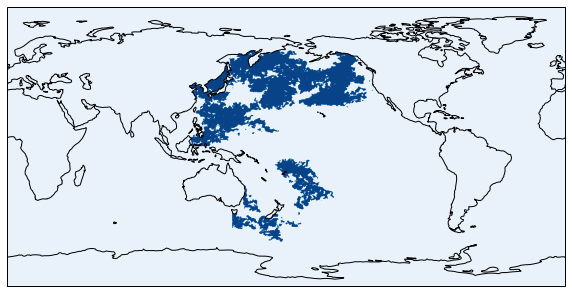

In [66]:
fig = plt.figure(figsize=(10, 6))
plt.clf()

proj = ccrs.PlateCarree(central_longitude=-180.0)
ax = plt.gca(projection=proj)

# Pacific events
# Draw the contour with 25 levels.
cm = plt.get_cmap('Blues')

cplt = iris.plot.contourf(any_big_cube, cmap=cm)  # , vmin=0, vmax=20)#, 5)
#cb = plt.colorbar(cplt, fraction=0.020, pad=0.04)
#cb.set_label('Blob')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.show()

## Longest duration MHW System

In [67]:
np.max(tst2_sys.zboxmax-tst2_sys.zboxmin)

2183